# Dimensionality Reduction

Exploring how close various dimensionality reduction techniques can get to the true dimensionality of a contrived dataset. 

In [1]:
# Initial Setup
%matplotlib inline
import skimage as ski
import skimage.data as skid
import SimpleITK as sitk
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# Document versions used, cause of course this will end up run on some server somewhere
print "Scikit Image:",ski.__version__
print "Simple ITK:",sitk.Version()
print "Matplotlib:",mpl.__version__
print "Numpy:",np.__version__
# this makes nice big plots
plt.rcParams["figure.figsize"] = (12,9)
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


Scikit Image: 0.13.0
Simple ITK: SimpleITK Version: 1.0.0 (ITK 4.11)
Compiled: Apr  6 2017 16:26:03

Matplotlib: 1.5.1
Numpy: 1.11.3


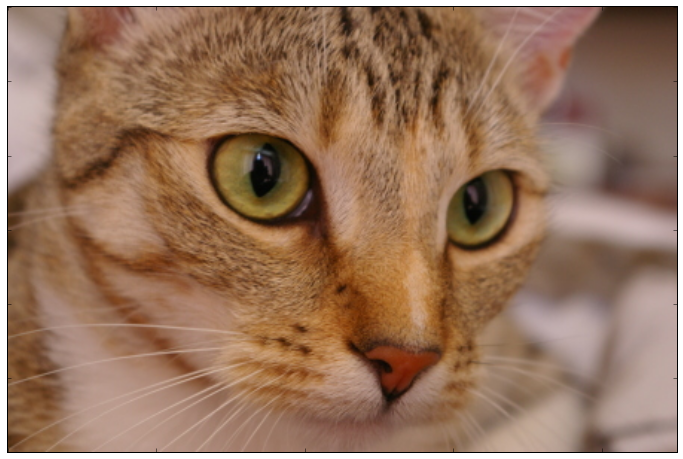

In [2]:
# Cats rule the internetz
z=skid.chelsea()
plt.imshow(z)
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

We will generate a grid of points, which will be moved and used to define a warp of the image.  The points will be moved in a circle - this is a one dimensional shape, so the inherent dimensionality of the generated images is one.  

(We could also transform the color space... future thought.)

[]

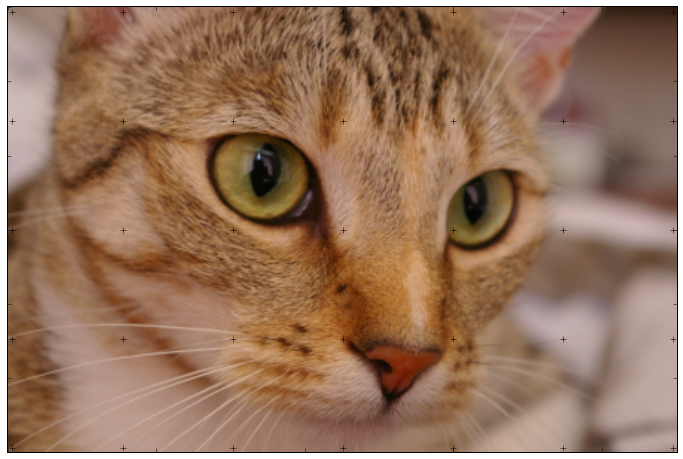

In [3]:
nbpoints=(7,5)
(x,y)=np.meshgrid(np.linspace(3,z.shape[1]-3,nbpoints[0]),np.linspace(3,z.shape[0]-3,nbpoints[1]))
plt.imshow(z)
yl=plt.ylim()
xl=plt.xlim()
plt.plot(x,y,'k+')
plt.ylim(yl)
plt.xlim(xl)
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])



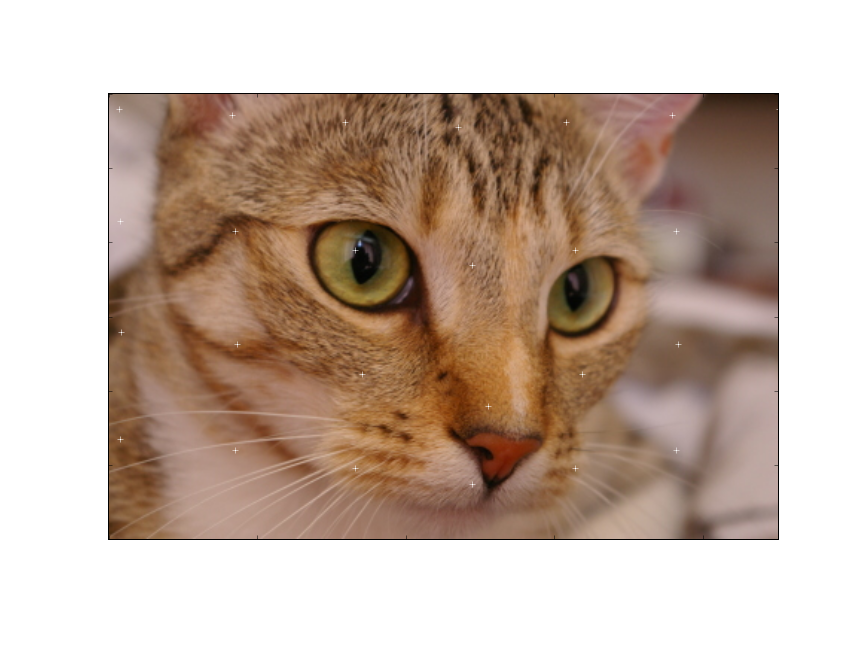
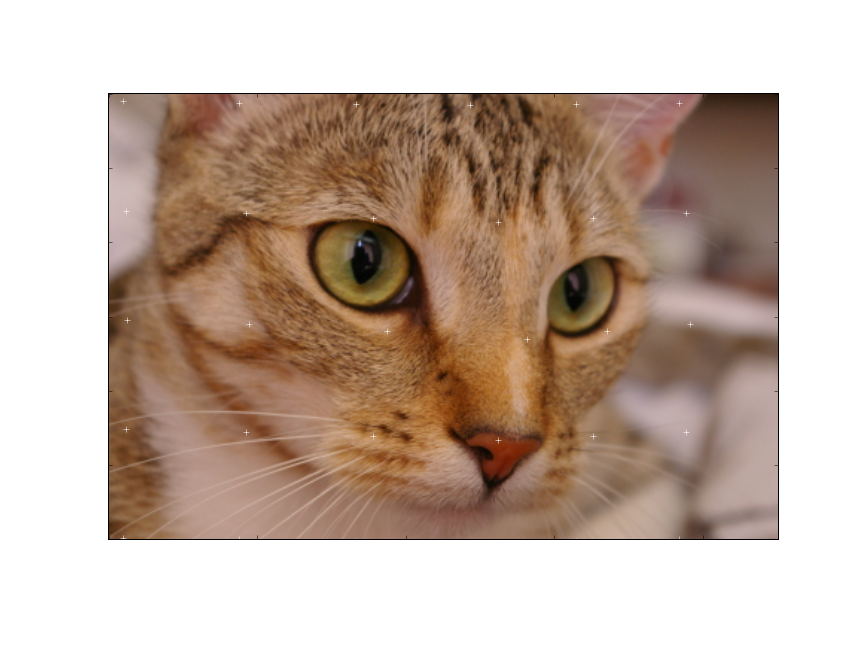
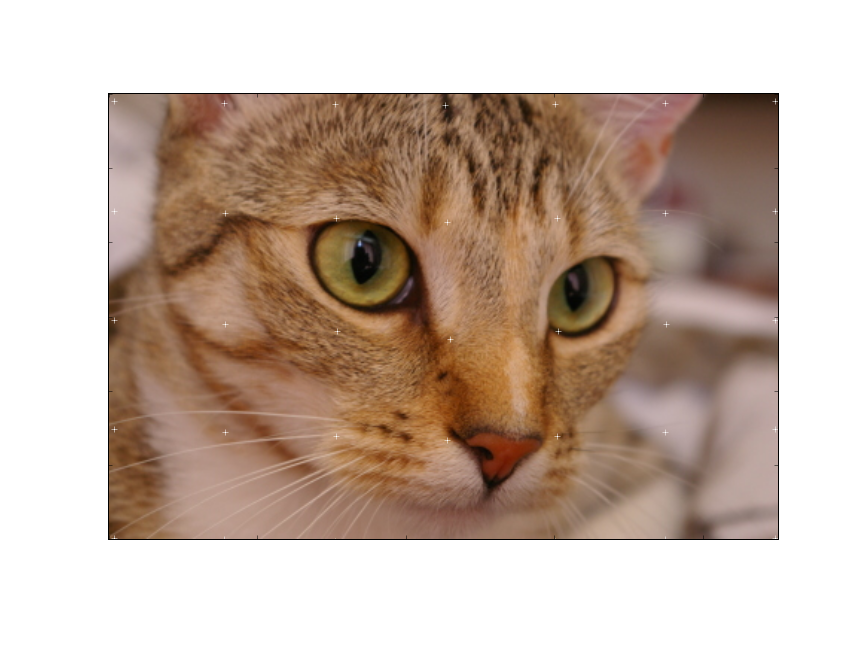

In [7]:
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

fig = plt.figure()
im=plt.imshow(z)
yl=plt.ylim()
xl=plt.xlim()
ax = plt.gca()
pts, = ax.plot([], [], 'w+')
radii=np.array([ np.sqrt((a-z.shape[1]/2.)**2+(b-z.shape[0]/2.)**2) for a,b in zip(x,y)])

fr=3
def rbf(x):
    return 1./(1+(x/100.)**2)


# Generate a set of points for each of 18 positions
fixedPoints=(x,y)
movingPoints=[]
for i in range(fr):
    angle=np.deg2rad(i*360./fr)
    movingPoints.append( (x+30.*rbf(radii)*(np.sin(angle)+1),
                          y+30.*rbf(radii)*(np.cos(angle)+1)) )

    
def init():
    pts.set_data([], [])
    return pts,

def animate(i):
    #yl=ax.get_ylim()
    #xl=ax.get_xlim()
    pts.set_data(x+30*rbf(radii)*(np.sin(np.deg2rad(i*360./fr))+1), y+30.*rbf(radii)*(np.cos(np.deg2rad(i*360/fr))+1))
    ax.set_ylim(yl)
    ax.set_xlim(xl)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    return pts,

anim=animation.FuncAnimation(fig, animate, init_func=init,
                        frames=fr, interval=50, blit=True)
display_animation(anim)

In [ ]:
fr=3

# Generate a set of points for each of 18 positions
fixedPoints=zip(*(x.ravel(),y.ravel()))
movingPoints=[]
for i in range(fr):
    angle=np.deg2rad(i*360./fr)
    movingPoints.append( (x+30.*rbf(radii)*(np.sin(angle)+1),
                          y+30.*rbf(radii)*(np.cos(angle)+1)) )

img=sitk.GetImageFromArray(z,isVector=True)
    
bspline = sitk.BSplineTransform(2,3)
bspline.SetTransformDomainOrigin(img.GetOrigin()-np.array((1,1)))
bspline.SetTransformDomainDirection(img.GetDirection())
bspline.SetTransformDomainPhysicalDimensions(img.GetSize())
bspline.SetTransformDomainMeshSize((7,5))



print zip(*fixedPoints)
initializer=sitk.LandmarkBasedTransformInitializer(bspline)
initializer.SetFixedPoints(fixedPoints)
initializer.SetMovingPoints(movingPoints)
